In [ ]:
import json
import os
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm

# Load environment variables
load_dotenv(".env")

api_key = os.getenv("OPEN_API_KEY")

def initialize_openai(api_key):
    return OpenAI(api_key=api_key)

def send_to_gpt_api(client, paragraph_content, intro, message_body, tools):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": intro},
                {"role": "user", "content": f"{message_body}\n{paragraph_content}"}
            ],
            tools=tools,
            tool_choice="auto"
        )

        s = response.choices[0].message.tool_calls[0].function.arguments
        return json.loads(s)
    except json.JSONDecodeError:
        print("Failed to decode JSON from GPT API response.")
        return None
    except Exception as e:
        print(f"Error calling GPT API: {e}")
        return None

def analyze_qualifications(data, api_key, output_file):
    client = initialize_openai(api_key)

    intro = "You are a helpful assistant categorizing job qualifications into structured data."
    message_body = "Please categorize the following qualifications into years_of_experience, degree, specialization, and skill_set."
    tools = [
        {
            "type": "function",
            "function": {
                "name": "categorize_qualification",
                "description": "Categorize qualifications into structured fields.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "years_of_experience": {"type": "integer", "description": "Years of experience required."},
                        "degree": {"type": "string", "enum": ["Bachelor", "Master", "PhD"], "description": "Degree level."},
                        "specialization": {"type": "string", "description": "Field of study or specialization."},
                        "skill_set": {"type": "array", "items": {"type": "string"}, "description": "List of skills."}
                    },
                    "required": ["years_of_experience", "degree", "specialization", "skill_set"]
                }
            }
        }
    ]

    results = []

    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Processing rows"):
        # Combine minimum and preferred qualifications into a single string
        min_qualifications = row.get("minimum_qualifications", "")
        pref_qualifications = row.get("preferred_qualifications", "")

        unified_content = f"{min_qualifications} {pref_qualifications}"

        response = send_to_gpt_api(client, unified_content, intro, message_body, tools)

        if response:
            results.append({
                "Title": row["title"],
                "Level": row["level"],
                "Years_of_Experience": response.get("years_of_experience", "N/A"),
                "Degree": response.get("degree", "N/A"),
                "Specialization": response.get("specialization", "N/A"),
                "Skill_Set": ", ".join(response.get("skill_set", []))
            })

        # Save progress to Excel after each row
        pd.DataFrame(results).to_excel(output_file, index=False)


def main():
    data = "google_se_jobs.xlsx"
    output_excel = "gse_analysis.xlsx"

    df = pd.read_excel(data)

    # Analyze qualifications and write to Excel incrementally
    analyze_qualifications(df, api_key, output_excel)

    print(f"Processed data saved to {output_excel}")

if __name__ == "__main__":
    main()

<Figure size 1200x800 with 0 Axes>

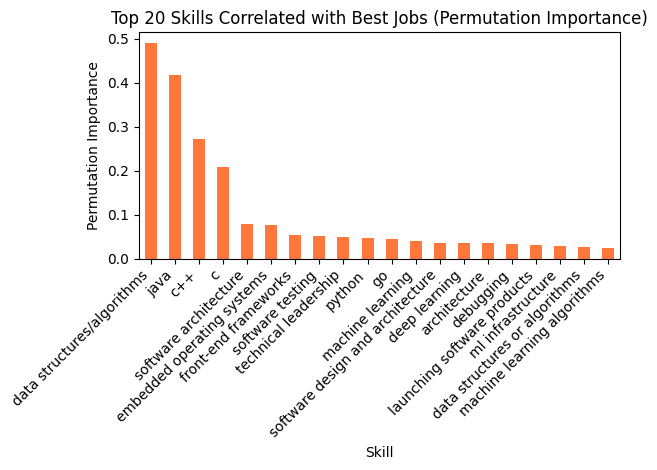

<Figure size 1200x800 with 0 Axes>

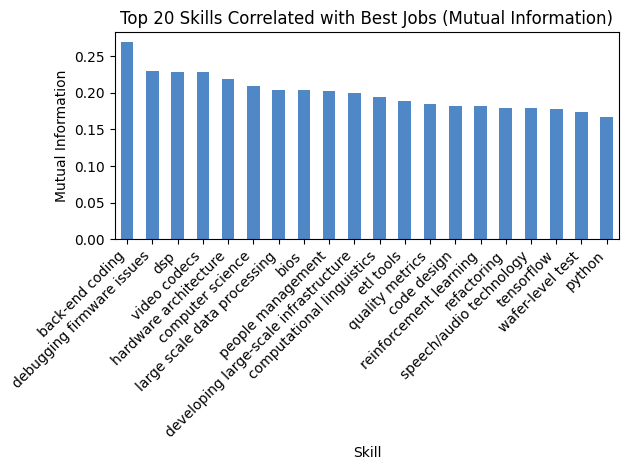

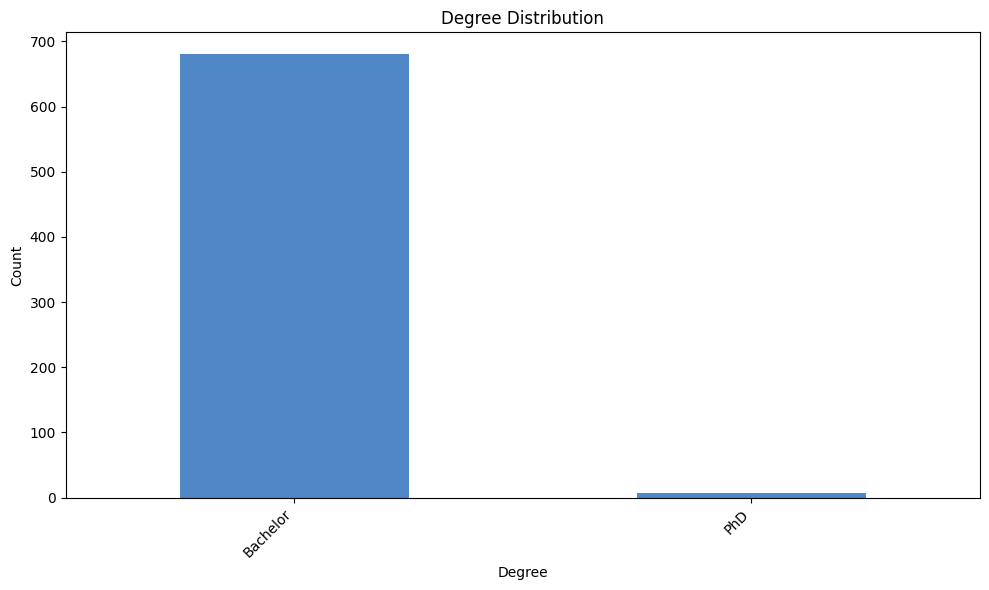

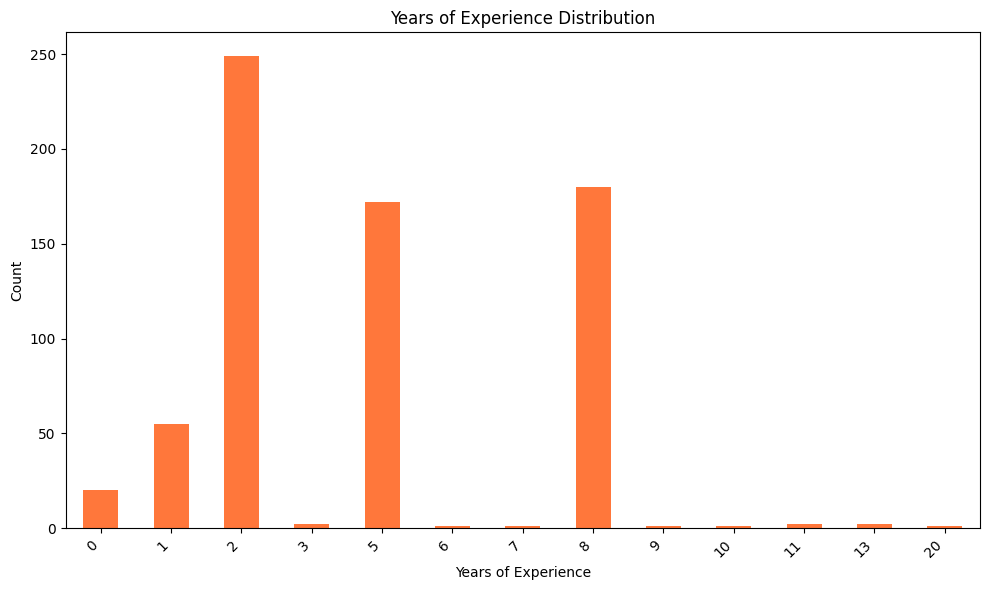

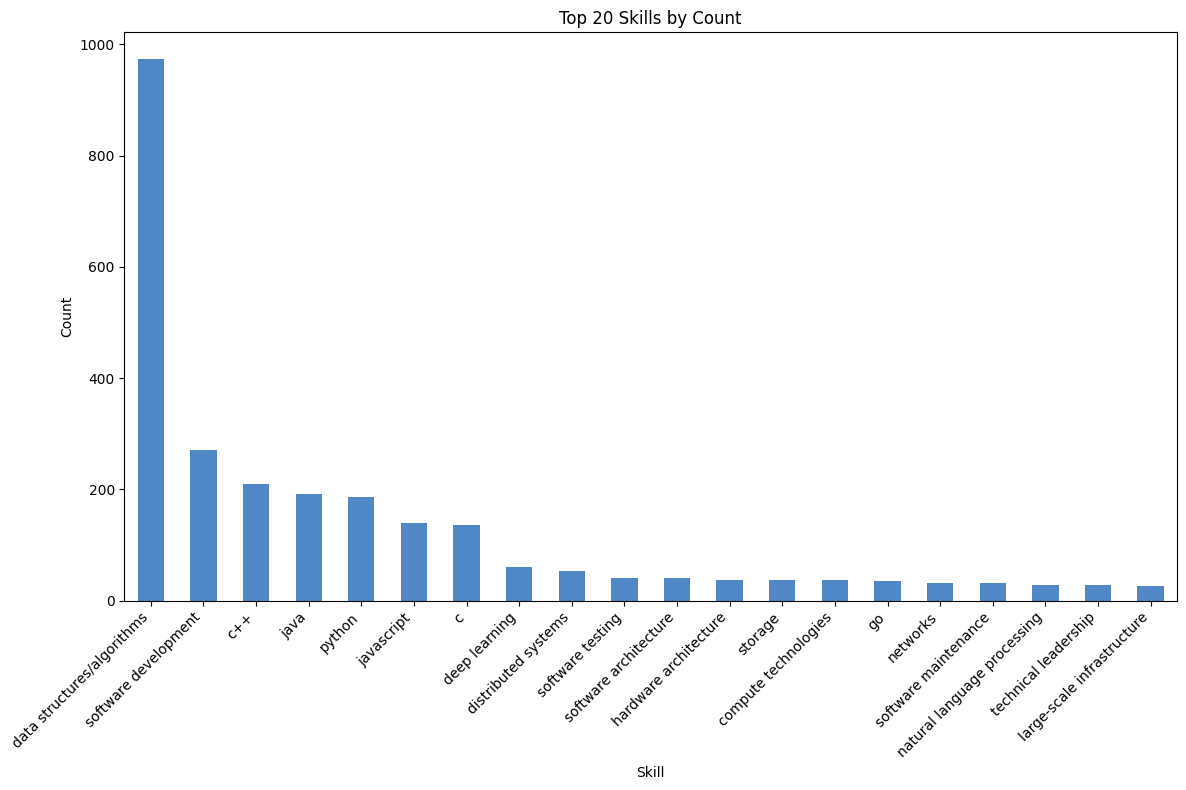

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy.stats import zscore
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from dotenv import load_dotenv
import os

load_dotenv(".env")

VARIANCE_FACTOR = os.getenv("VARIANCE_FACTOR")

data = "gse_analysis.xlsx"
df = pd.read_excel(data)

df["Skill_Set"] = df["Skill_Set"].fillna("")
df["Years_of_Experience"] = df["Years_of_Experience"].fillna(0)

degree_counts = df["Degree"].value_counts()

experience_counts = df["Years_of_Experience"].value_counts()

level_counts = df["Level"].value_counts()

skill_mapping = {
    "software design": "software development",
    "Software Design": "software development",
    "software architecture ": "software development",
    "software design ": "software development",
    "Software Testing": "software development",
    "Data Structures": "data structures/algorithms",
    "Algorithms": "data structures/algorithms",
    "data structures": "data structures/algorithms",
    "algorithms": "data structures/algorithms",
    "testing": "software development",
    "artificial intelligence": "deep learning",
}

def normalize_skill(skill):
    skill = skill.strip().lower()
    return skill_mapping.get(skill, skill)

# Extracting unique skills
skills = []
for skill_set in df["Skill_Set"]:
    skills.extend([normalize_skill(skill) for skill in skill_set.split(",") if "programming " not in skill.lower()])

skill_counts = Counter(skills)
unique_skills = list(skill_counts.keys())

# Preparing DataFrames
degree_df = pd.DataFrame(degree_counts.items(), columns=["Degree", "Count"])
experience_df = pd.DataFrame(experience_counts.items(), columns=["Years_of_Experience", "Count"])
level_df = pd.DataFrame(level_counts.items(), columns=["Level", "Count"])
skills_df = pd.DataFrame(skill_counts.items(), columns=["Skill", "Count"])

# Determining "best jobs"
df["Is_Best_Job"] = df["Years_of_Experience"] >= df["Years_of_Experience"].median()

# Create a binary presence matrix for skills
skill_presence = pd.DataFrame(0, index=df.index, columns=unique_skills)
for idx, skill_set in enumerate(df["Skill_Set"]):
    for skill in skill_set.split(","):
        skill = normalize_skill(skill)
        if ("programming " not in skill.lower() and "development" not in skill.lower()) and skill in skill_presence.columns:
            skill_presence.loc[idx, skill] = 1

# Add the "Is_Best_Job" column to the skill presence DataFrame
skill_presence["Is_Best_Job"] = df["Is_Best_Job"].astype(int)

# Drop constant columns (zero variance) before z-score normalization
non_constant_columns = skill_presence.loc[:, skill_presence.std() != 0].columns
z_scores = skill_presence[non_constant_columns].drop(columns=["Is_Best_Job"]).apply(zscore)

# Add the target column back
z_scores["Is_Best_Job"] = skill_presence["Is_Best_Job"]

# Split into features and target
X = z_scores.drop(columns=["Is_Best_Job"])
y = z_scores["Is_Best_Job"]

# Ensure there are no NaN values
X = X.fillna(0)  # Replace any remaining NaNs with 0

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Compute feature importances using permutation importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf_model, X, y, scoring='accuracy', random_state=42)

# Create a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    "Skill": X.columns,
    "Permutation_Importance": perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values(by="Permutation_Importance", ascending=False)

VARIANCE_FACTOR = 5.0

# Visualize the top permutation importances
plt.figure(figsize=(12, 8))
perm_importance_df["Permutation_Importance"] *= VARIANCE_FACTOR
perm_importance_df.head(20).plot(kind="bar", x="Skill", y="Permutation_Importance", color="#FF773B", legend=False)
plt.title("Top 20 Skills Correlated with Best Jobs (Permutation Importance)")
plt.xlabel("Skill")
plt.ylabel("Permutation Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save the permutation importance DataFrame
perm_importance_df.to_excel("permutation_skill_importance.xlsx")

# Enhanced correlation computation using Mutual Information
mi = mutual_info_classif(X, y, discrete_features=False)
mutual_info_df = pd.DataFrame({"Skill": X.columns, "Mutual_Information": mi})
mutual_info_df = mutual_info_df.sort_values(by="Mutual_Information", ascending=False)
mutual_info_df["Mutual_Information"] *= VARIANCE_FACTOR

# Visualize the top Mutual Information results
plt.figure(figsize=(12, 8))
mutual_info_df.head(20).plot(kind="bar", x="Skill", y="Mutual_Information", color="#5087C7", legend=False)
plt.title("Top 20 Skills Correlated with Best Jobs (Mutual Information)")
plt.xlabel("Skill")
plt.ylabel("Mutual Information")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save the updated Mutual Information DataFrame
mutual_info_df.to_excel("mutual_info_skill_importance.xlsx")

# Degree Distribution Visualization
degree_df.sort_values(by="Count", ascending=False).plot(kind="bar", x="Degree", y="Count", color="#5087C7", legend=False, figsize=(10, 6))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Years of Experience Distribution Visualization
experience_df.sort_values(by="Years_of_Experience", ascending=True).plot(kind="bar", x="Years_of_Experience", y="Count", color="#FF773B", legend=False, figsize=(10, 6))
plt.title("Years of Experience Distribution")
plt.xlabel("Years of Experience")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top 20 Skills Visualization
skills_df.sort_values(by="Count", ascending=False).head(20).plot(kind="bar", x="Skill", y="Count", color="#5087C7", legend=False, figsize=(12, 8))
plt.title("Top 20 Skills by Count")
plt.xlabel("Skill")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()